# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../fastai/') #fastai version 1.0

from fastai.vision import *

import pandas as pd
import numpy as np
import os
import torch
import torchvision
from torchsummary import summary
from pathlib import Path
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import roc_curve, f1_score, fbeta_score

PATH = Path('/home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection')
TRAIN_NAME = 'train'
TRAIN = PATH/TRAIN_NAME
CSV_NAME = 'train_labels.csv'
LABELS = PATH/CSV_NAME
TEST_NAME = 'test'
TEST = PATH/TEST_NAME
SAMPLE = PATH/'sample_submission.csv'
SUBMISSIONS = PATH/'submissions'
SUBMISSIONS.mkdir(exist_ok=True)

nw = 16   #number of workers for data loader
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True
np.random.seed(42)

sz = 96
bs = 128

# Data 

In [2]:
data = (ImageItemList.from_csv(path=PATH, csv_name=CSV_NAME, folder=TRAIN_NAME, suffix='.tif')
.random_split_by_pct(0.2)
.label_from_df()
.add_test_folder(test_folder=TEST_NAME, label=None)
.transform(get_transforms(flip_vert=True), size=sz)
.databunch(bs=bs, num_workers=nw)
.normalize(imagenet_stats))

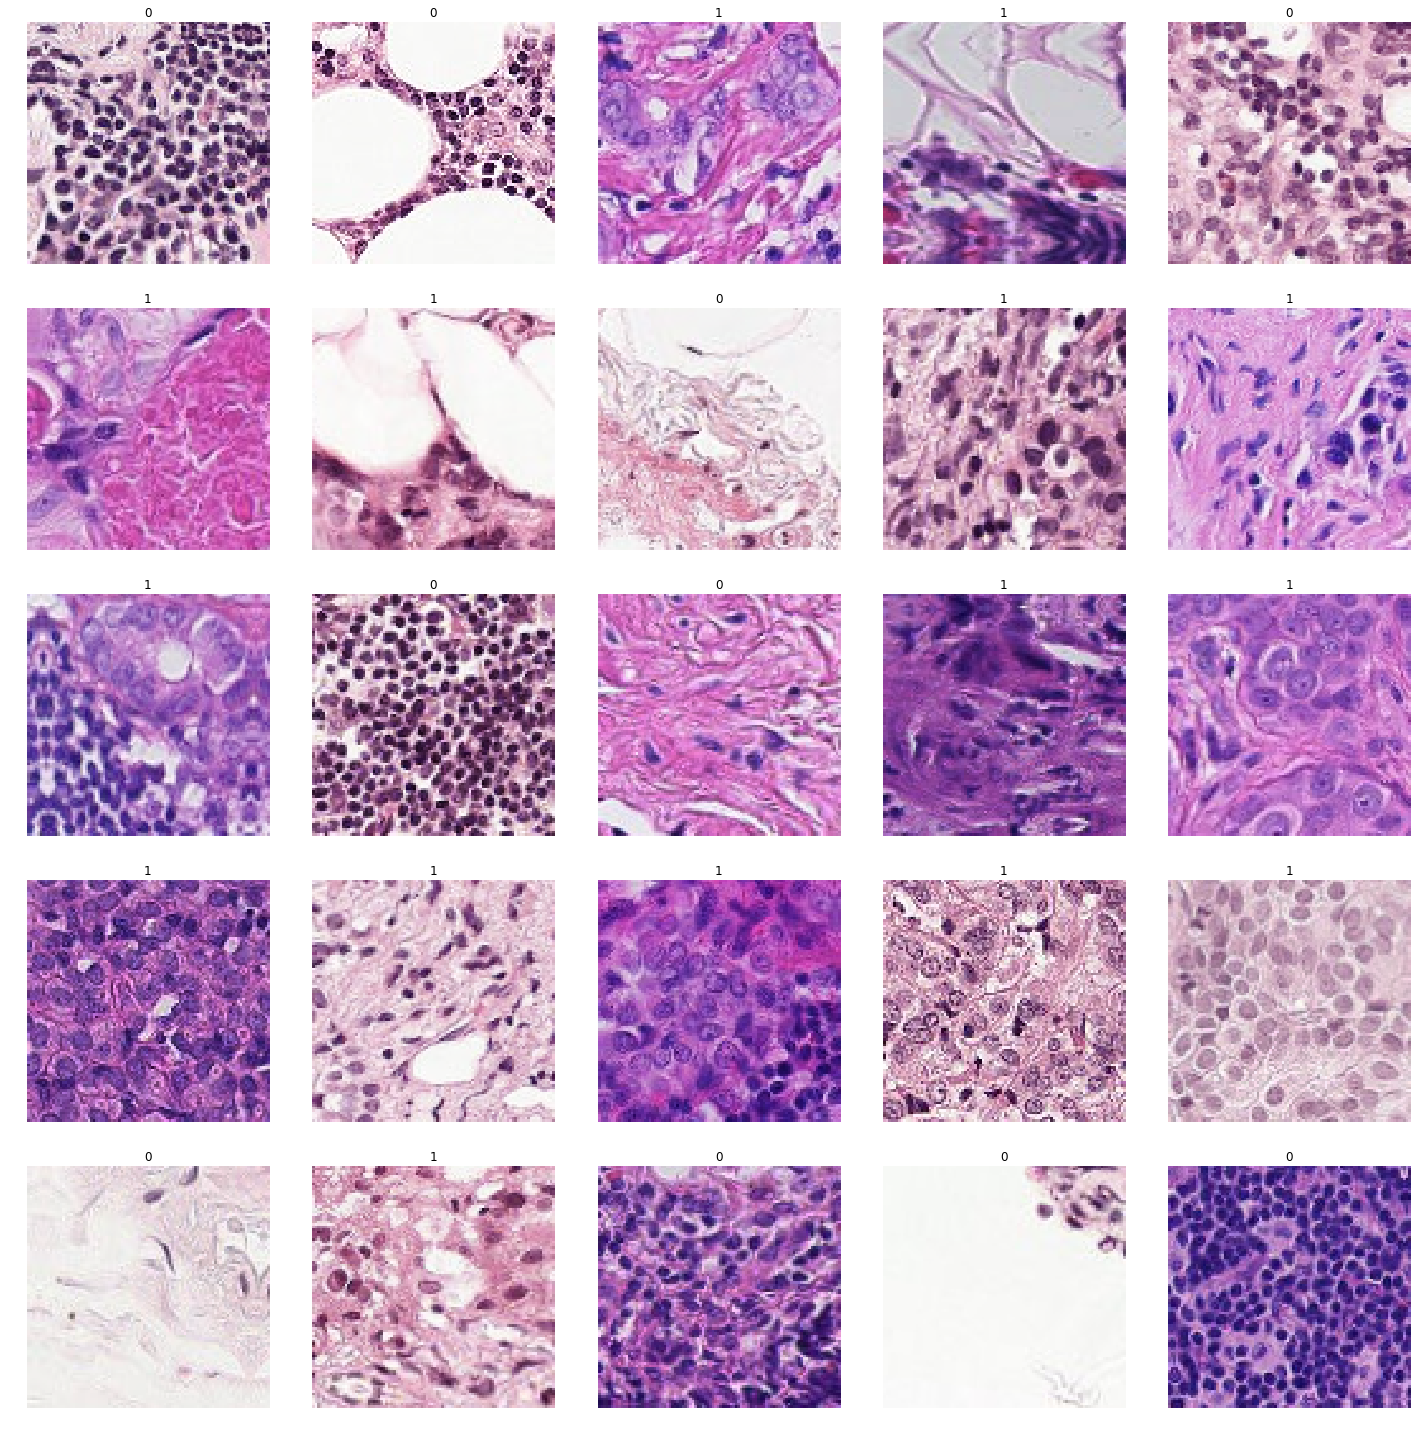

In [4]:
data.show_batch()

# Learner

## Create

In [3]:
arch = torchvision.models.resnet50

In [4]:
learner = create_cnn(data=data, 
                     arch=arch, 
                     metrics=[accuracy])

## Train

In [5]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


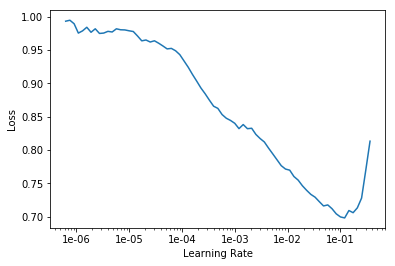

In [6]:
learner.recorder.plot()

In [11]:
lr = 1e-2
cycle_len_head=5

In [ ]:
learner.fit_one_cycle(cycle_len_head, slice(lr))

In [ ]:
learner.recorder.plot_lr(show_moms=True)

In [ ]:
learner.save(f'{arch.__name__}-head')

In [6]:
learner.load('resnet50-head')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (176020 items)
[Category 0, Category 1, Category 0, Category 0, Category 0]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection
x: ImageItemList (176020 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection;

Valid: LabelList
y: CategoryList (44005 items)
[Category 0, Category 1, Category 0, Category 0, Category 1]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection
x: ImageItemList (44005 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection;

Test: LabelList
y: EmptyLabelList (57458 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (57458 items)
[Image

In [7]:
learner.unfreeze()

In [8]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


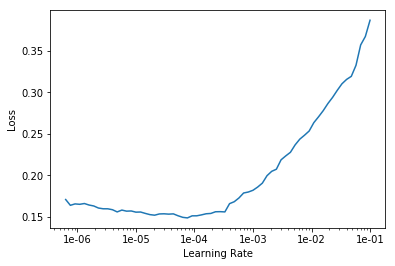

In [9]:
learner.recorder.plot()

In [20]:
lr2 = 1e-5

In [12]:
learner.fit_one_cycle(cyc_len=1, max_lr=slice(lr2, lr/5))

epoch,train_loss,valid_loss,accuracy
1,0.149396,0.119367,0.957096


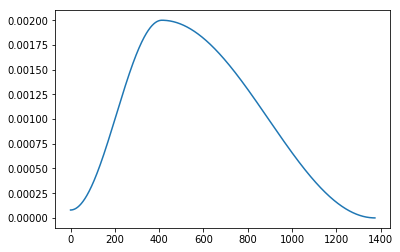

In [13]:
learner.recorder.plot_lr()

In [14]:
learner.save(f'{arch.__name__}-complete-1')

epoch,train_loss,valid_loss,accuracy
1,0.151710,0.132558,0.950710
2,0.117313,0.103587,0.963004


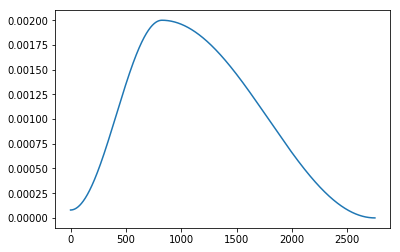

In [15]:
learner.fit_one_cycle(cyc_len=2, max_lr=slice(lr2, lr/5))
learner.recorder.plot_lr()
learner.save(f'{arch.__name__}-complete-2')

epoch,train_loss,valid_loss,accuracy
1,0.139794,0.119252,0.957255
2,0.125170,0.115113,0.958164
3,0.107394,0.092442,0.967322
4,0.090649,0.090092,0.968890


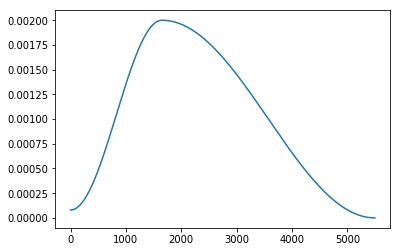

In [17]:
learner.fit_one_cycle(cyc_len=4, max_lr=slice(lr2, lr/5))
learner.recorder.plot_lr()
learner.save(f'{arch.__name__}-complete-3')

epoch,train_loss,valid_loss,accuracy
1,0.108450,0.097394,0.965458
2,0.116108,0.106072,0.963095
3,0.112058,0.100635,0.964186
4,0.086022,0.084450,0.970912
5,0.082883,0.081713,0.970912
6,0.069958,0.077234,0.972321


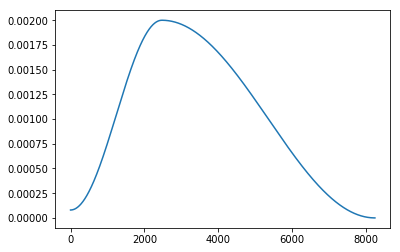

In [19]:
learner.fit_one_cycle(cyc_len=6, max_lr=slice(lr2, lr/5))
learner.recorder.plot_lr()
learner.save(f'{arch.__name__}-complete-4')

epoch,train_loss,valid_loss,accuracy
1,0.072122,0.080197,0.971321
2,0.076660,0.087566,0.972162
3,0.077762,0.078887,0.972776
4,0.070409,0.076694,0.973139
5,0.070783,0.073485,0.974957
6,0.068790,0.072949,0.974435
7,0.067622,0.073835,0.974094
8,0.057429,0.073932,0.974026


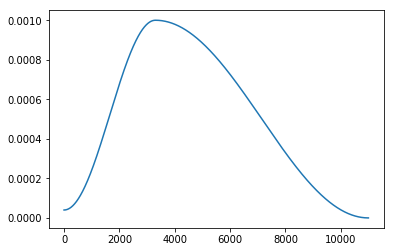

In [21]:
learner.fit_one_cycle(cyc_len=8, max_lr=slice(lr2/10, lr/10))
learner.recorder.plot_lr()
learner.save(f'{arch.__name__}-complete-5')

epoch,train_loss,valid_loss,accuracy
1,0.061565,0.073237,0.974798
2,0.058475,0.073333,0.974253
3,0.058036,0.073755,0.974412
4,0.064055,0.073075,0.974707
5,0.059303,0.071938,0.975116
6,0.061731,0.072562,0.975253
7,0.061684,0.072375,0.974912
8,0.056020,0.073141,0.974412


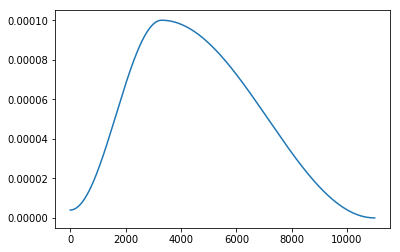

In [22]:
learner.fit_one_cycle(cyc_len=8, max_lr=slice(lr2/100, lr/100))
learner.recorder.plot_lr()
learner.save(f'{arch.__name__}-complete-6')

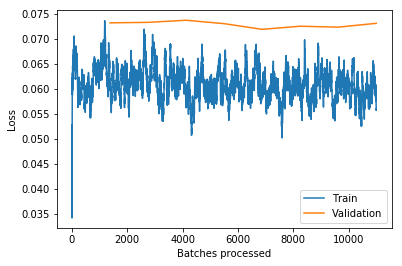

In [23]:
learner.recorder.plot_losses()

## Load

In [5]:
learner.load('resnet50-complete-5')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (176020 items)
[Category 0, Category 1, Category 0, Category 0, Category 0]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection
x: ImageItemList (176020 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection;

Valid: LabelList
y: CategoryList (44005 items)
[Category 0, Category 1, Category 0, Category 0, Category 1]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection
x: ImageItemList (44005 items)
[Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96), Image (3, 96, 96)]...
Path: /home/Deep_Learner/work/network/datasets/Histopathologic-Cancer-Detection;

Test: LabelList
y: EmptyLabelList (57458 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (57458 items)
[Image

# Interpretation

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(16)

# Predictions

In [22]:
preds, _ = learner.TTA(ds_type=DatasetType.Test)

In [24]:
pred_labels = []
for p in tqdm(np.array(preds)):
    if p[0] > p[1]:
        pred_labels.append(0)
    if p[0] < p[1]:
        pred_labels.append(1)
    if p[0] == p[1]:
        pred_labels.append(1)
        print('same')

In [25]:
df = pd.DataFrame({'id':[fname.split('.')[0] for fname in os.listdir(TEST)], 'label':pred_labels})

In [26]:
name = f'5-{arch.__name__}_sz{sz}_bs{bs}.csv'

In [27]:
df.to_csv(SUBMISSIONS/name, header=True, index=False)